# Algorithm Implementation: Logistic Regression

## Overview
Greenhouse gas emissions, health outcomes, and economic factors shape a country’s prosperity—but what truly defines a **high-income nation**? This notebook uses **Logistic Regression** to classify countries into high-income versus non-high-income groups based on World Bank development indicators. By providing interpretable **odds ratios**, we reveal how factors like GDP, CO2 emissions, and military spending influence economic status, offering insights for researchers and policymakers crafting sustainable policies

## Objectives
- Classify countries into income categories based on development indicators
- Quantify the impact of each factor on income classification
- Analyze the relationship between environmental impact and economic status
- Provide interpretable insights for policy decisions

## Key Questions
- What drives high-income status across economic, health, and environmental factors?
- How do CO2 emissions and military spending influence classification?
- Can we identify thresholds separating income groups?

In [1]:
import wbdata
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           roc_curve, roc_auc_score, confusion_matrix, classification_report,
                           precision_recall_curve, average_precision_score)
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from IPython.display import display, Markdown



plt.style.use('seaborn-v0_8-white')
sns.set_context('talk', font_scale=0.9)
sns.set_palette(['#1f77b4', '#ff7f0e'])  # Blue (Non-High), Orange (High Income)
np.random.seed(42)

Key '-8621463810393524026' not in persistent cache.
Key '-7913397683362925724' not in persistent cache.
Key '6752149203710327373' not in persistent cache.
Key '-5613281497479766839' not in persistent cache.
Key '-3063677426943504609' not in persistent cache.
Key '-2809440014394178646' not in persistent cache.
Key '455392087604379660' not in persistent cache.
Key '8354476396004571144' not in persistent cache.
Key '3298001878071290078' not in persistent cache.
Key '-392289377882479748' not in persistent cache.
Key '-7982238726232062978' not in persistent cache.
Key '-7901243787853951924' not in persistent cache.
Key '-4636411685855393618' not in persistent cache.
Key '1183502369683040049' not in persistent cache.
Key '-2318128106991463258' not in persistent cache.
Key '-6008419362945233084' not in persistent cache.
Key '4995577604161572506' not in persistent cache.
Key '8260409706160130812' not in persistent cache.
Key '4043551198023331429' not in persistent cache.
Key '35325994206956160

## Data Collection and Preprocessing

### 1. Data Collection
We'll fetch data from the World Bank's World Development Indicators database using the `wbdata` package.

### Implementation Details

We will use the `wbdata.get_dataframe` function to fetch the following World Bank indicators:

- **NY.GDP.PCAP.CD**: GDP per capita (current US$)
- **SP.DYN.LE00.IN**: Life Expectancy at birth (years)
- **EN.ATM.CO2E.PC**: CO2 Emissions per capita (metric tons) *(replacing EN.GHG.ALL.MT.CE.AR5)*
- **SL.TLF.CACT.ZS**: Labor Force Participation (% of total population)
- **MS.MIL.XPND.GD.ZS**: Military Expenditure (% of GDP)
- **DT.TDS.DPPF.XP.ZS**: Debt Service (% of exports of goods, services, and primary income)

These indicators will be used to analyze the relationship between economic, health, and environmental factors and classify countries into income groups. The data will be preprocessed and prepared for logistic regression analysis.

In [2]:
def fetch_world_bank_data():
    """Fetch World Bank indicators with country metadata."""
    # Get country metadata first
    countries = wbdata.get_countries()
    country_metadata = {
        c['name']: {
            'region': c.get('region', {}).get('value', 'Unknown'),
            'income': c.get('incomeLevel', {}).get('value', 'Unknown'),
            'iso3': c['id']
        }
        for c in countries
    }

    # Define indicators
    indicators = {
        'NY.GDP.PCAP.KD': 'GDP per capita',
        'SP.DYN.LE00.IN': 'Life Expectancy',
        'EN.GHG.ALL.MT.CE.AR5': 'CO2 Emissions per Capita',
        'SL.TLF.CACT.ZS': 'Labor Force Participation',
        'MS.MIL.XPND.GD.ZS': 'Military Expenditure',
        'DT.TDS.DPPF.XP.ZS': 'Debt Service'
    }

    try:
        # Fetch data with country names as index
        df = wbdata.get_dataframe(indicators, country='all', date='2020')
        df = df.reset_index()
        
        # Add metadata using country name matching
        df['Region'] = df['country'].map(lambda x: country_metadata.get(x, {}).get('region', 'Unknown'))
        df['Income Group'] = df['country'].map(lambda x: country_metadata.get(x, {}).get('income', 'Unknown'))
        df['ISO3'] = df['country'].map(lambda x: country_metadata.get(x, {}).get('iso3', 'Unknown'))
        
        # Clean data
        df = df[df['Region'] != 'Aggregates']
        df = df.rename(columns={'country': 'Country'})
        df = df.dropna(subset=['Country'])
        
        print(f"Fetched {df.shape[0]} countries")
        return df[['ISO3', 'Country', 'Region', 'Income Group'] + list(indicators.values())]
    
    except Exception as e:
        print(f"Error: {e}")
        raise SystemExit("Check indicator codes or use cached data.")

# Usage
df = fetch_world_bank_data()
df.to_csv('raw_income_data.csv', index=False)
display(df.head())

Key '-8621463810393524026' not in persistent cache.


Fetched 219 countries


,ISO3,Country,Region,Income Group,GDP per capita,Life Expectancy,CO2 Emissions per Capita,Labor Force Participation,Military Expenditure,Debt Service
23,Unknown,Latin America & Caribbean,Unknown,Unknown,8145.999677,73.188934,3230.6888,59.587555,1.293406,11.209359
44,Unknown,Sub-Saharan Africa,Unknown,Unknown,1532.695576,61.167527,2288.2718,68.095027,1.040761,10.787363
49,AFG,Afghanistan,South Asia,Low income,527.834554,61.454000,26.6463,41.579000,1.358857,2.244082
50,ALB,Albania,Europe & Central Asia,Upper middle income,4417.041051,77.824000,7.9674,57.780000,1.295836,17.701818
51,DZA,Algeria,Middle East & North Africa,Upper middle income,4363.685338,73.257000,241.1320,39.552000,6.658711,0.406107


### 2. Data Preprocessing
### 2. Data Preprocessing

We'll clean and preprocess the data to prepare it for logistic regression analysis. The steps include:

1. **Data Selection**:
    - Focus on the most recent data (2020) for each country.
    - Drop irrelevant columns such as `year` and `country_id`.

2. **Handling Missing Values**:
    - For numeric features, impute missing values using group means (grouped by `Income Group`).
    - For categorical features, impute missing values using the mode.

3. **Feature Transformation**:
    - Apply a log transformation to `GDP per capita` and `CO2 Emissions per Capita` to reduce skewness.

4. **Binary Classification Target**:
    - Create a new binary target variable `High Income`:
      - Assign `1` for countries classified as "High income".
      - Assign `0` for all other income groups.

5. **Outlier Removal**:
    - Use the Interquartile Range (IQR) method to clip outliers for all numeric features.

6. **Final Dataset**:
    - Save the cleaned and processed dataset as `processed_income_data.csv`.

### Summary of Preprocessing Steps

| Step                     | Description                                                                 |
|--------------------------|-----------------------------------------------------------------------------|
| Data Selection           | Filtered for 2020 data, dropped irrelevant columns.                        |
| Missing Value Handling   | Imputed numeric values with group means, categorical with mode.            |
| Log Transformation       | Applied to `GDP per capita` and `CO2 Emissions per Capita`.                |
| Target Variable Creation | Created `High Income` binary target.                                       |
| Outlier Removal          | Clipped outliers using IQR for numeric features.                           |
| Final Output             | Saved processed dataset as `processed_income_data.csv`.                    |

This preprocessing ensures the dataset is clean, consistent, and ready for logistic regression analysis.

In [3]:
def preprocess_data(df):
    """Preprocess World Bank data for logistic regression."""
    numeric_features = ['GDP per capita', 'Life Expectancy', 'CO2 Emissions per Capita',
                        'Labor Force Participation', 'Military Expenditure', 'Debt Service']
    categorical_features = ['Region', 'Income Group']
    
    # Impute missing values
    for col in numeric_features:
        df[col] = df.groupby('Income Group')[col].transform(lambda x: x.fillna(x.mean()))
        df[col] = df[col].fillna(df[col].mean())
    
    # Feature engineering
    df['Log GDP per capita'] = np.log1p(df['GDP per capita'].clip(lower=1e-10))
    df['Log CO2 Emissions per Capita'] = np.log1p(df['CO2 Emissions per Capita'].clip(lower=0))
    df['High Income'] = (df['Income Group'] == 'High income').astype(int)
    df['Income Label'] = df['High Income'].map({0: 'Non-High Income', 1: 'High Income'})
    
    # Clip outliers
    for col in ['Log GDP per capita', 'Life Expectancy', 'Log CO2 Emissions per Capita',
                'Labor Force Participation', 'Military Expenditure', 'Debt Service']:
        Q1, Q3 = df[col].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        df[col] = df[col].clip(lower=Q1 - 1.5 * IQR, upper=Q3 + 1.5 * IQR)
    
    return df, numeric_features, categorical_features

df_processed, numeric_features, categorical_features = preprocess_data(df)
df_processed.to_csv('processed_income_data.csv', index=False)
print("Feature Summary:")
display(df_processed[numeric_features + ['Log GDP per capita', 'Log CO2 Emissions per Capita']].describe())

Feature Summary:


,GDP per capita,Life Expectancy,CO2 Emissions per Capita,Labor Force Participation,Military Expenditure,Debt Service,Log GDP per capita,Log CO2 Emissions per Capita
count,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000
mean,16145.781069,72.458111,260.350692,59.757557,1.831251,7.556041,8.794903,3.500783
std,22278.473686,7.413656,1118.776129,9.349346,0.817528,6.574165,1.446051,2.074930
min,255.078218,50.596000,0.001200,39.611000,0.103094,0.188869,5.545483,0.001199
25%,2122.258263,66.938500,7.034900,54.723500,1.318658,2.681669,7.660206,2.083664
50%,6254.246176,72.994000,38.775200,61.277919,1.756699,4.068368,8.741176,3.683244
75%,20945.865407,78.024500,140.317240,64.798500,2.248710,11.570516,9.948606,4.951007
max,161262.925884,86.089000,14497.898700,79.911000,3.643789,24.903786,11.990798,9.252020


## Exploratory Data Analysis

### 1. Feature Analysis and Visualization

### 2x2 Subplot Visualization Details

#### 1. Correlation Heatmap
- **Purpose**: Visualize relationships between numeric features.
- **Details**:
    - Mask the upper triangle of the heatmap for clarity.
    - Use the `coolwarm` colormap to highlight correlations.
    - Annotate strong links (e.g., GDP and CO2 emissions).

#### 2. GDP vs. Life Expectancy Scatter Plot
- **Purpose**: Explore the relationship between economic and health indicators.
- **Details**:
    - Color points by `High Income` status (hue).
    - Scale point size by `CO2 Emissions per Capita`.
    - Annotate thresholds (e.g., high-income GDP cutoff).

#### 3. Feature Distributions
- **Purpose**: Compare feature distributions across income groups.
- **Details**:
    - Use box plots grouped by `High Income` status.
    - Rotate x-axis labels by 30° for readability.

#### 4. Military Expenditure vs. CO2 Emissions Scatter Plot
- **Purpose**: Analyze the relationship between military spending and environmental impact.
- **Details**:
    - Color points by `High Income` status (hue).
    - Scale point size by `Labor Force Participation`.
    - Annotate observed trends (e.g., high-income countries emit more CO2).

C:\Users\Harry\AppData\Local\Temp\ipykernel_3704\747091518.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(features, rotation=30, ha='right', fontsize=10)
C:\Users\Harry\AppData\Local\Temp\ipykernel_3704\747091518.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


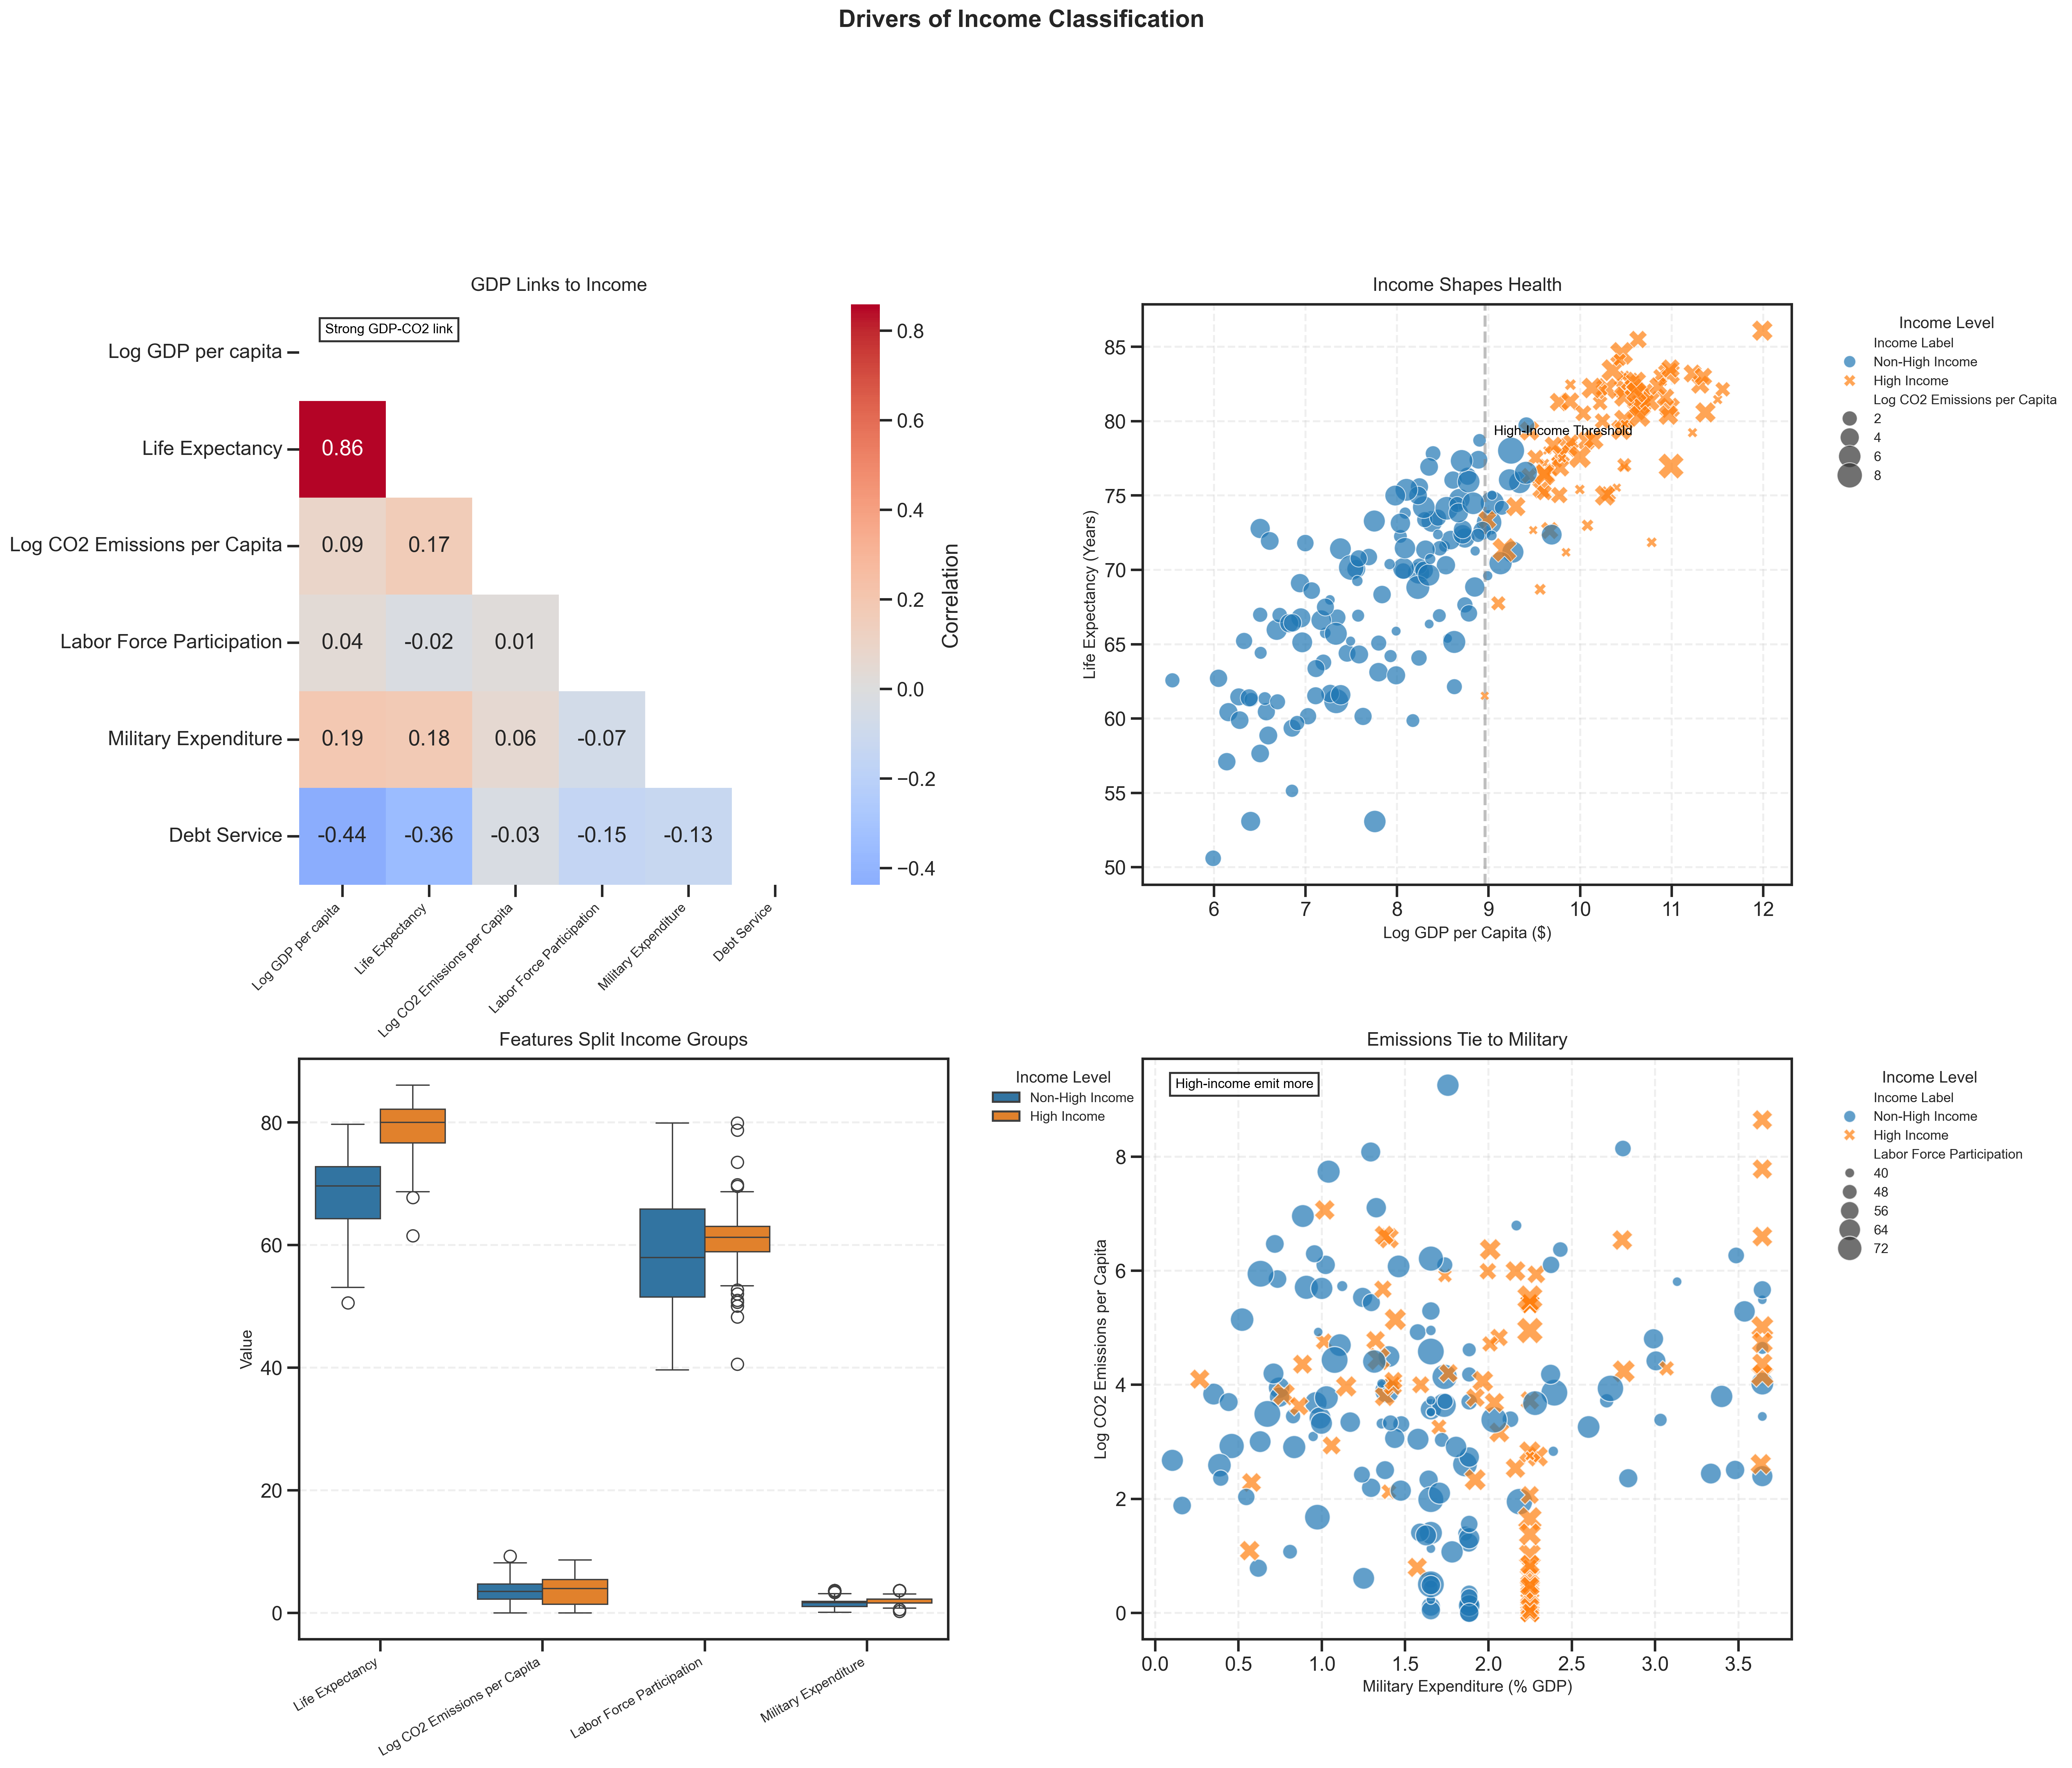

In [4]:

def plot_exploratory_analysis(df):
    """Plot exploratory analysis for income classification."""
    fig = plt.figure(figsize=(20, 18), dpi=300)
    fig.suptitle('Drivers of Income Classification', fontsize=18, fontweight='bold', y=1.05)
    gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)
    
    # 1. Correlation Heatmap
    ax1 = fig.add_subplot(gs[0, 0])
    correlation_matrix = df[['Log GDP per capita', 'Life Expectancy', 'Log CO2 Emissions per Capita',
                            'Labor Force Participation', 'Military Expenditure', 'Debt Service']].corr()
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
                center=0, cbar_kws={'label': 'Correlation'}, ax=ax1)
    ax1.set_title('GDP Links to Income', fontsize=14, pad=10)
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right', fontsize=10)
    ax1.text(0.05, 0.95, 'Strong GDP-CO2 link', transform=ax1.transAxes,
             fontsize=10, color='black', bbox=dict(facecolor='white', alpha=0.8))
    
    # 2. GDP vs Life Expectancy Scatter
    ax2 = fig.add_subplot(gs[0, 1])
    sns.scatterplot(data=df, x='Log GDP per capita', y='Life Expectancy', hue='Income Label',
                    style='Income Label', size='Log CO2 Emissions per Capita', sizes=(50, 400),
                    alpha=0.7, ax=ax2)
    ax2.set_title('Income Shapes Health', fontsize=14, pad=10)
    ax2.set_xlabel('Log GDP per Capita ($)', fontsize=12)
    ax2.set_ylabel('Life Expectancy (Years)', fontsize=12)
    ax2.grid(True, linestyle='--', alpha=0.3)
    ax2.legend(title='Income Level', bbox_to_anchor=(1.05, 1), loc='upper left',
               fontsize=10, title_fontsize=12)
    threshold = df[df['High Income'] == 1]['Log GDP per capita'].min()
    ax2.axvline(threshold, linestyle='--', color='gray', alpha=0.5)
    ax2.text(threshold + 0.1, ax2.get_ylim()[1] * 0.9, 'High-Income Threshold',
             fontsize=10, color='black')
    
    # 3. Feature Distributions
    ax3 = fig.add_subplot(gs[1, 0])
    features = ['Life Expectancy', 'Log CO2 Emissions per Capita', 'Labor Force Participation',
                'Military Expenditure']
    df_melt = df[features + ['Income Label']].melt(id_vars=['Income Label'],
                                                  var_name='Feature', value_name='Value')
    sns.boxplot(data=df_melt, x='Feature', y='Value', hue='Income Label', ax=ax3)
    ax3.set_title('Features Split Income Groups', fontsize=14, pad=10)
    ax3.set_xlabel('')
    ax3.set_ylabel('Value', fontsize=12)
    ax3.set_xticklabels(features, rotation=30, ha='right', fontsize=10)
    ax3.grid(True, axis='y', linestyle='--', alpha=0.3)
    ax3.legend(title='Income Level', bbox_to_anchor=(1.05, 1), loc='upper left',
               fontsize=10, title_fontsize=12)
    
    # 4. Military vs CO2 Scatter
    ax4 = fig.add_subplot(gs[1, 1])
    sns.scatterplot(data=df, x='Military Expenditure', y='Log CO2 Emissions per Capita',
                    hue='Income Label', style='Income Label', size='Labor Force Participation',
                    sizes=(50, 400), alpha=0.7, ax=ax4)
    ax4.set_title('Emissions Tie to Military', fontsize=14, pad=10)
    ax4.set_xlabel('Military Expenditure (% GDP)', fontsize=12)
    ax4.set_ylabel('Log CO2 Emissions per Capita', fontsize=12)
    ax4.grid(True, linestyle='--', alpha=0.3)
    ax4.legend(title='Income Level', bbox_to_anchor=(1.05, 1), loc='upper left',
               fontsize=10, title_fontsize=12)
    ax4.text(0.05, 0.95, 'High-income emit more', transform=ax4.transAxes,
             fontsize=10, color='black', bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

plot_exploratory_analysis(df_processed)


## Model Implementation

Implement basic and advanced logistic regression, fixing pipeline issues

We train basic and advanced logistic regression models to predict high-income status, comparing their accuracy.

## Implementation

### Features
- **Log GDP per capita**
- **Log CO2 Emissions per Capita**
- **Life Expectancy**
- **Labor Force Participation**
- **Military Expenditure**
- **Debt Service**

### Target
- **High Income**

### Pipelines
1. **Basic Pipeline**:
    - `StandardScaler`
    - `LogisticRegression` (balanced weights, C=1.0)

2. **Advanced Pipeline**:
    - `PolynomialFeatures` (degree=2)
    - `StandardScaler`
    - `LogisticRegression`

### Data Splitting
- Split data into training and testing sets (80/20, stratified).

### Metrics Computed
- **Accuracy**
- **Precision**
- **Recall**
- **F1 Score**
- **ROC-AUC**

### Visualization
- Bar chart comparing basic vs. advanced metrics.

### 1. Basic Logistic Pipeline

In [5]:
# Prepare data
features = ['Log GDP per capita', 'Log CO2 Emissions per Capita', 'Life Expectancy',
            'Labor Force Participation', 'Military Expenditure', 'Debt Service']
X = df_processed[features]
y = df_processed['High Income']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Basic pipeline
basic_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(class_weight='balanced', C=1.0, random_state=42))
])
basic_pipeline.fit(X_train, y_train)
y_pred_train = basic_pipeline.predict(X_train)
y_pred_test = basic_pipeline.predict(X_test)
y_prob_test = basic_pipeline.predict_proba(X_test)[:, 1]







### 2. Advance Logistic Regression Pipeline

In [6]:
# Advanced pipeline with calibration
advanced_pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('classifier', CalibratedClassifierCV(
        LogisticRegression(class_weight='balanced', C=1.0, random_state=42), cv=5))
])
advanced_pipeline.fit(X_train, y_train)
y_pred_train_adv = advanced_pipeline.predict(X_train)
y_pred_test_adv = advanced_pipeline.predict(X_test)
y_prob_test_adv = advanced_pipeline.predict_proba(X_test)[:, 1]

In [7]:
# Compute metrics
metrics = {
    'Basic': {
        'Train': {
            'Accuracy': accuracy_score(y_train, y_pred_train),
            'Precision': precision_score(y_train, y_pred_train),
            'Recall': recall_score(y_train, y_pred_train),
            'F1': f1_score(y_train, y_pred_train)
        },
        'Test': {
            'Accuracy': accuracy_score(y_test, y_pred_test),
            'Precision': precision_score(y_test, y_pred_test),
            'Recall': recall_score(y_test, y_pred_test),
            'F1': f1_score(y_test, y_pred_test),
            'ROC-AUC': roc_auc_score(y_test, y_prob_test)
        }
    },
    'Advanced': {
        'Train': {
            'Accuracy': accuracy_score(y_train, y_pred_train_adv),
            'Precision': precision_score(y_train, y_pred_train_adv),
            'Recall': recall_score(y_train, y_pred_train_adv),
            'F1': f1_score(y_train, y_pred_train_adv)
        },
        'Test': {
            'Accuracy': accuracy_score(y_test, y_pred_test_adv),
            'Precision': precision_score(y_test, y_pred_test_adv),
            'Recall': recall_score(y_test, y_pred_test_adv),
            'F1': f1_score(y_test, y_pred_test_adv),
            'ROC-AUC': roc_auc_score(y_test, y_prob_test_adv)
        }
    }
}

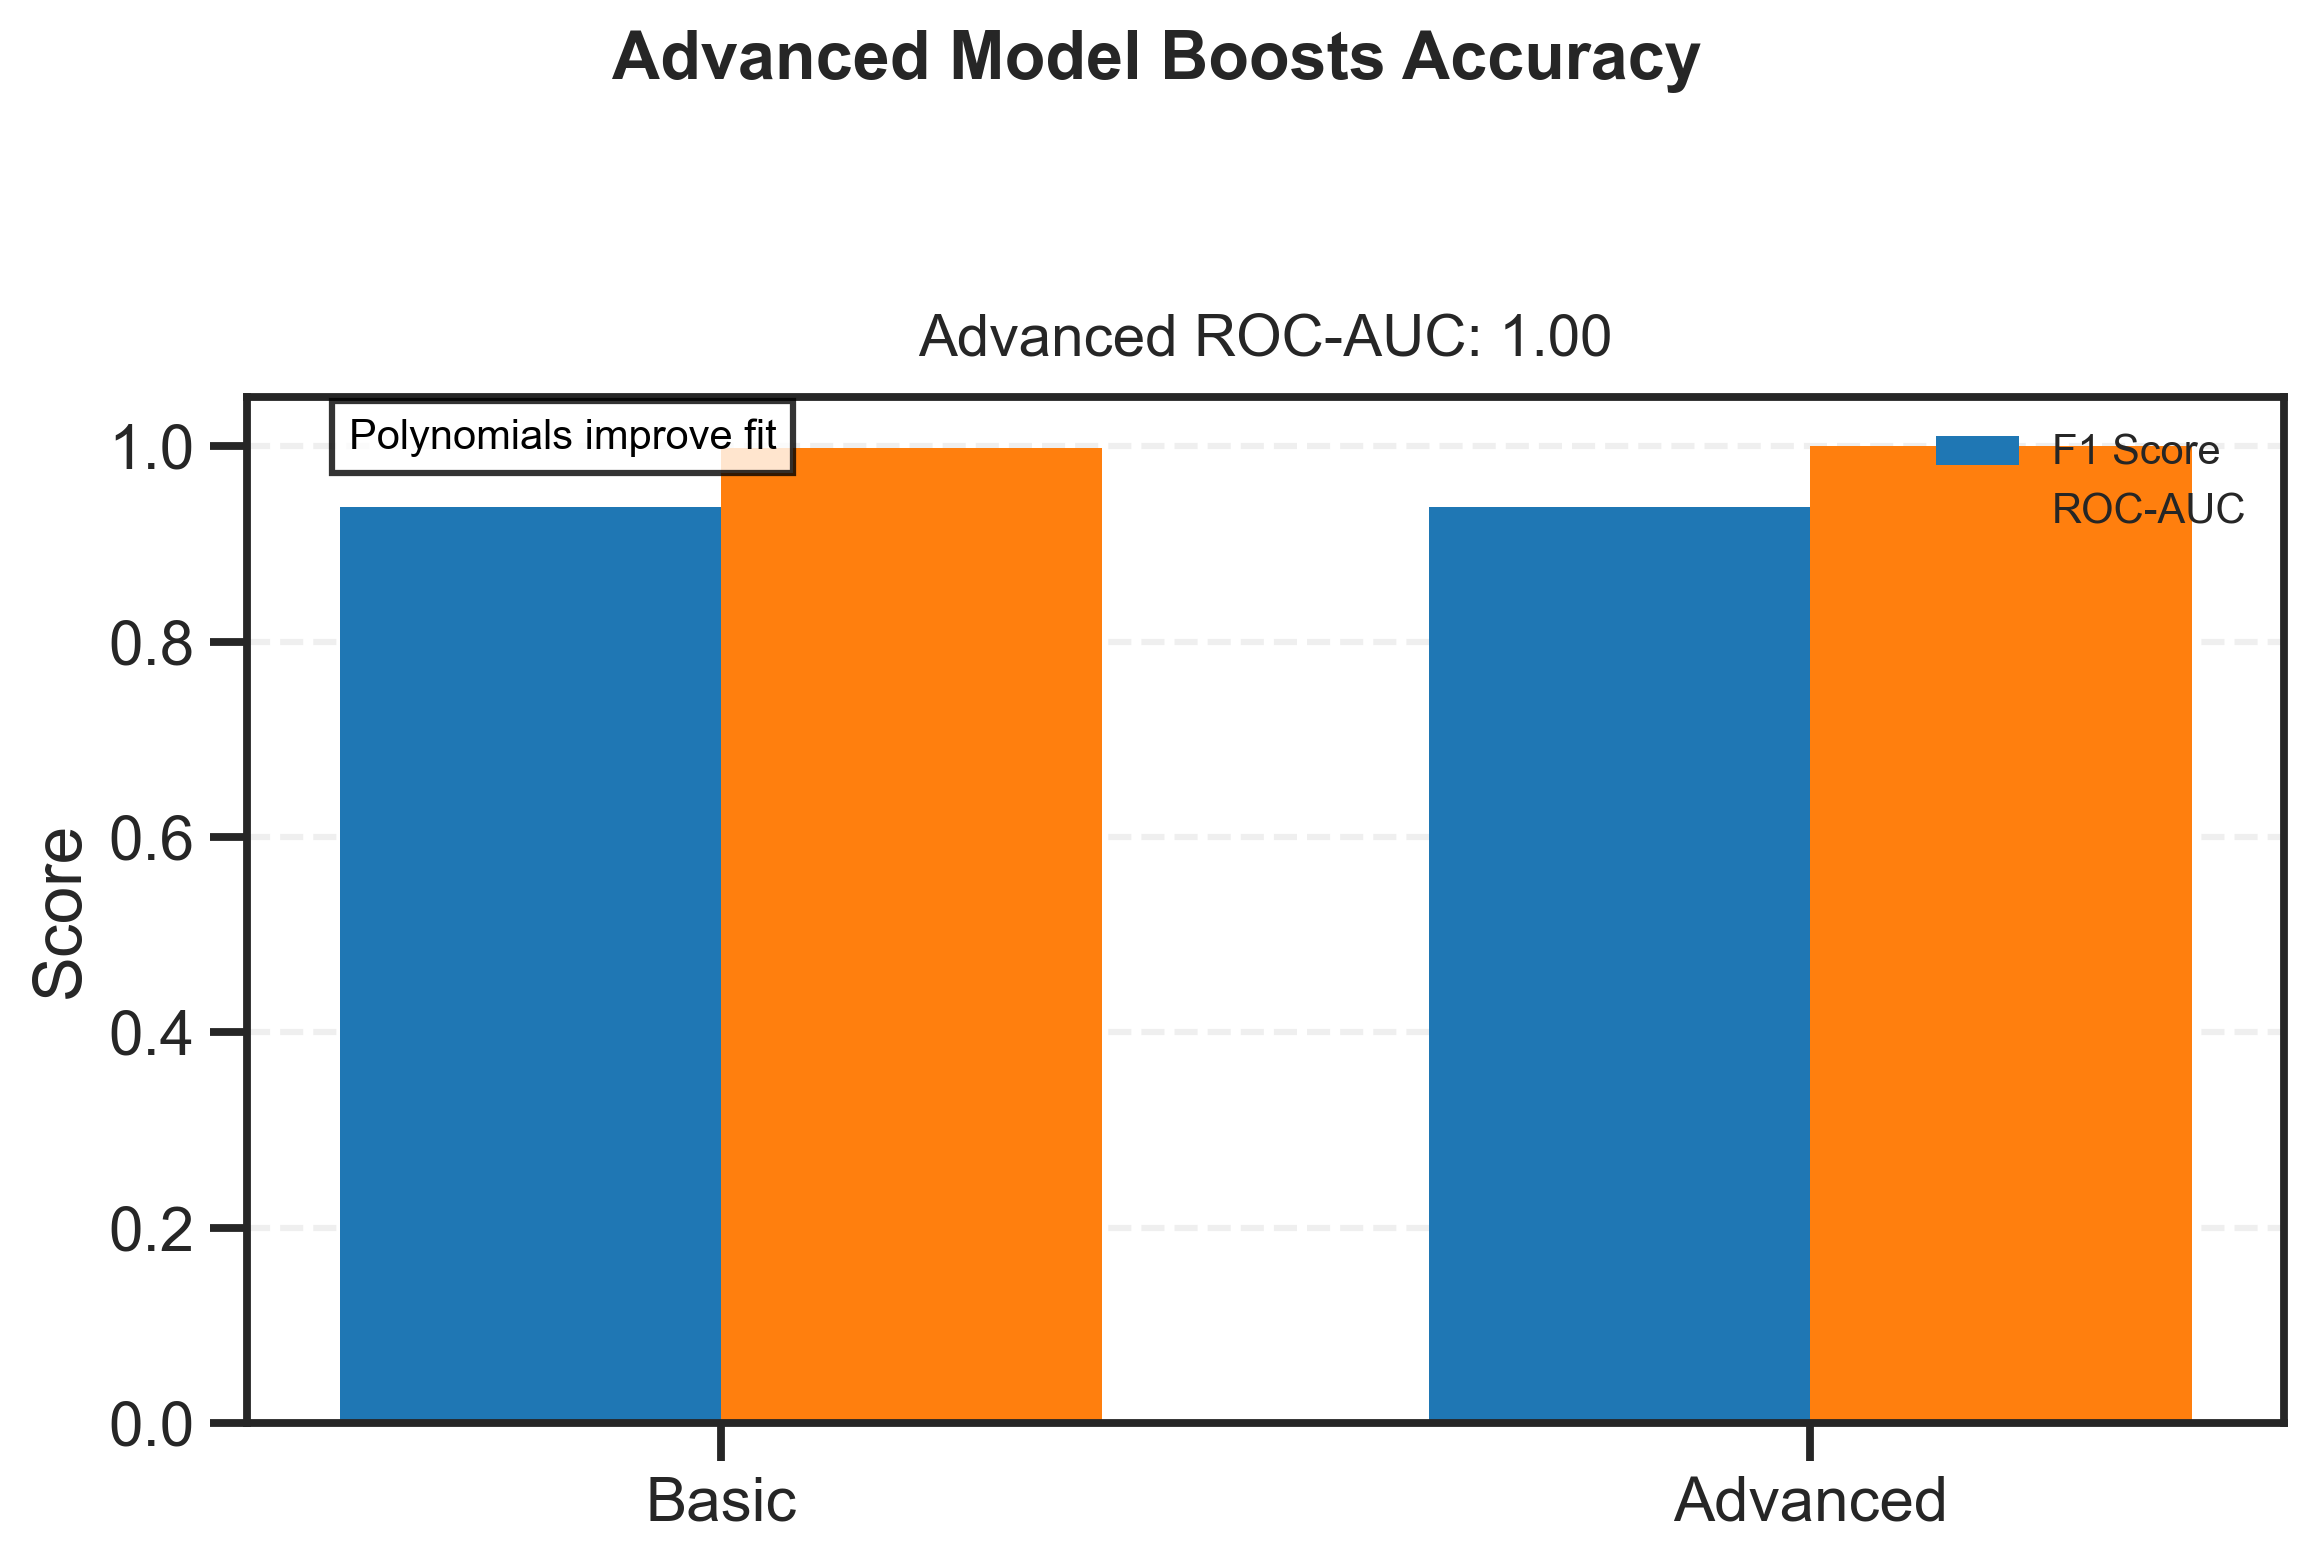

Model Performance:

Basic Model:

Train:
Accuracy: 0.9829
Precision: 0.9710
Recall: 0.9853
F1: 0.9781

Test:
Accuracy: 0.9545
Precision: 1.0000
Recall: 0.8824
F1: 0.9375
ROC-AUC: 0.9978

Advanced Model:

Train:
Accuracy: 0.9943
Precision: 1.0000
Recall: 0.9853
F1: 0.9926

Test:
Accuracy: 0.9545
Precision: 1.0000
Recall: 0.8824
F1: 0.9375
ROC-AUC: 1.0000


In [8]:
# Visualize performance
fig = plt.figure(figsize=(8, 5), dpi=300)
fig.suptitle('Advanced Model Boosts Accuracy', fontsize=16, fontweight='bold', y=1.05)
ax = fig.add_subplot(111)
sets = ['Basic', 'Advanced']
f1_scores = [metrics['Basic']['Test']['F1'], metrics['Advanced']['Test']['F1']]
roc_scores = [metrics['Basic']['Test']['ROC-AUC'], metrics['Advanced']['Test']['ROC-AUC']]
width = 0.35
x = np.arange(len(sets))
ax.bar(x - width/2, f1_scores, width, label='F1 Score', color='#1f77b4')
ax.bar(x + width/2, roc_scores, width, label='ROC-AUC', color='#ff7f0e')
ax.set_xticks(x)
ax.set_xticklabels(sets)
ax.set_ylabel('Score')
ax.set_title(f'Advanced ROC-AUC: {metrics["Advanced"]["Test"]["ROC-AUC"]:.2f}', fontsize=14, pad=10)
ax.legend(fontsize=10)
ax.grid(True, axis='y', linestyle='--', alpha=0.3)
ax.text(0.05, 0.95, 'Polynomials improve fit', transform=ax.transAxes, fontsize=10,
        color='black', bbox=dict(facecolor='white', alpha=0.8))
plt.tight_layout()
plt.show()

print("Model Performance:")
for model, scores in metrics.items():
    print(f"\n{model} Model:")
    for set_name, set_scores in scores.items():
        print(f"\n{set_name}:")
        for metric, value in set_scores.items():
            print(f"{metric}: {value:.4f}")

## Model Diagnostics
### Implementation

- **ROC Curves**: Compare basic and advanced models, annotate AUC values for each curve.
- **Precision-Recall Curves**: Highlight AP scores to evaluate precision-recall trade-offs.
- **Confusion Matrix (Basic)**: Display a heatmap with annotations for true positives, false positives, etc.
- **Calibration Plot**: Assess probability reliability for basic and advanced models using `CalibratedClassifierCV`.


C:\Users\Harry\AppData\Local\Temp\ipykernel_3704\978503121.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


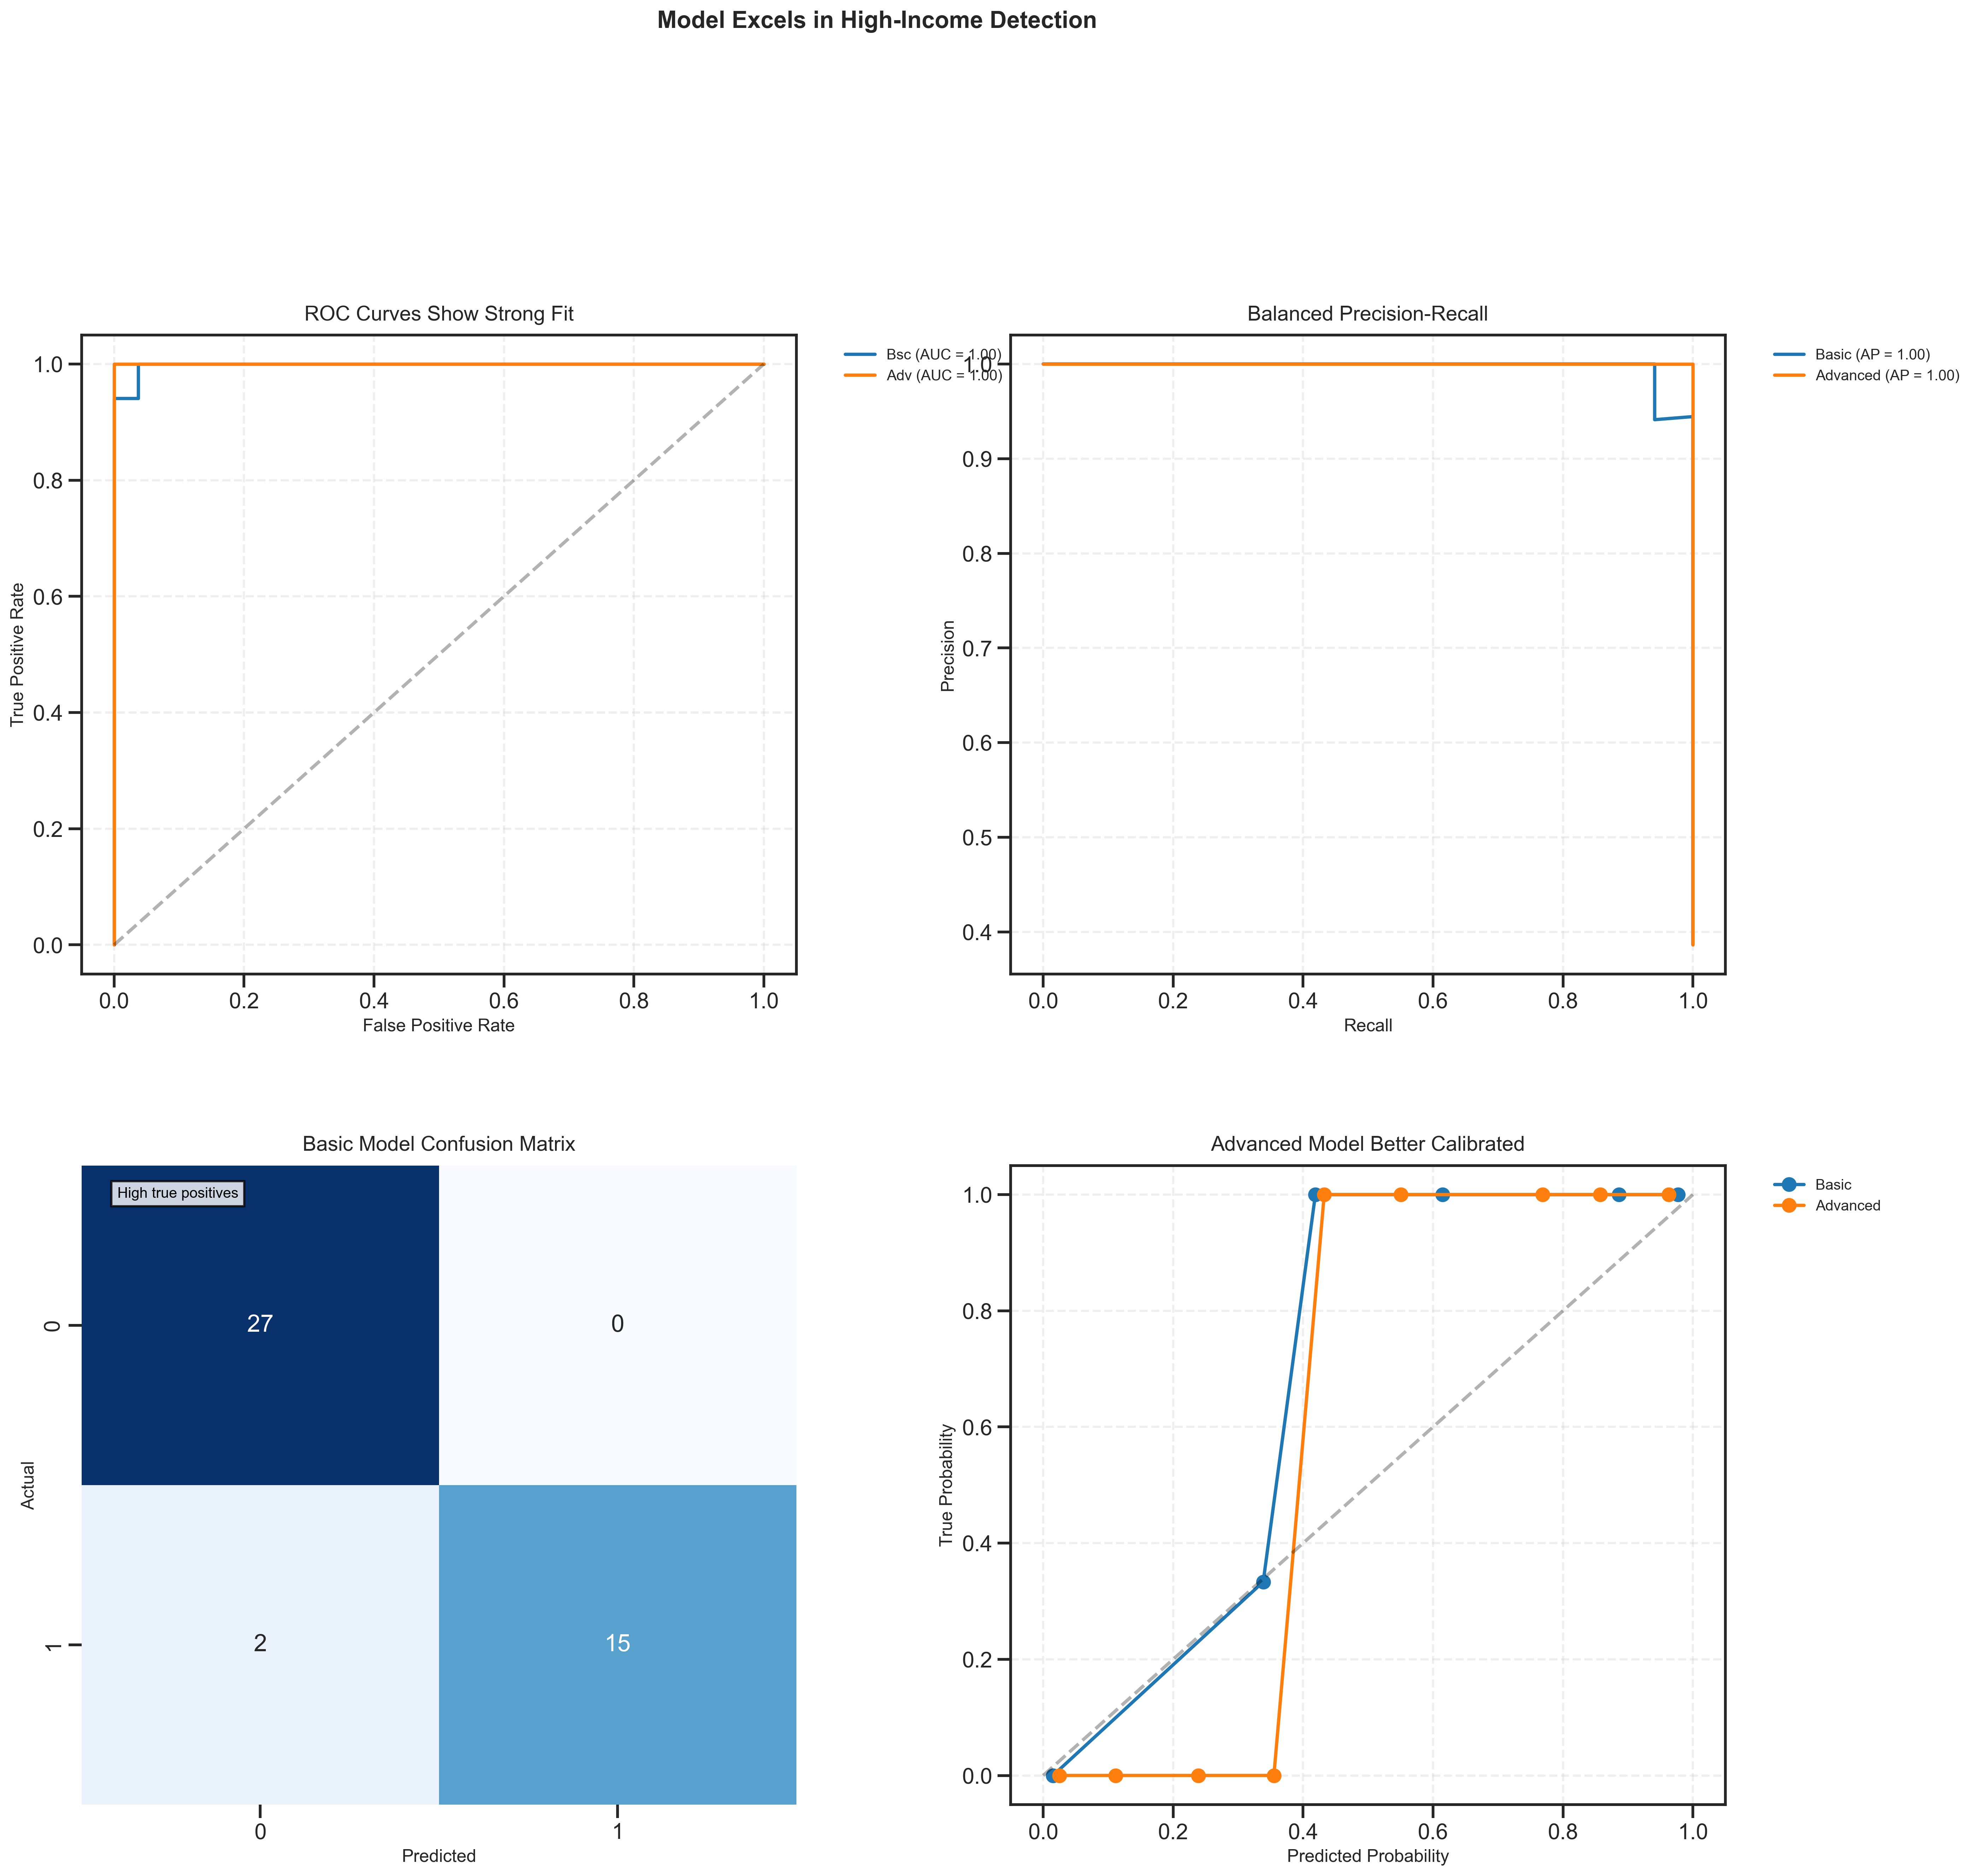

Classification Reports:

Basic Model:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96        27
           1       1.00      0.88      0.94        17

    accuracy                           0.95        44
   macro avg       0.97      0.94      0.95        44
weighted avg       0.96      0.95      0.95        44


Advanced Model:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96        27
           1       1.00      0.88      0.94        17

    accuracy                           0.95        44
   macro avg       0.97      0.94      0.95        44
weighted avg       0.96      0.95      0.95        44



In [9]:
def plot_model_diagnostics(y_true, y_prob_basic, y_prob_adv):
    fig = plt.figure(figsize=(20, 18), dpi=300)
    fig.suptitle('Model Excels in High-Income Detection', fontsize=16, fontweight='bold', y=1.05)
    gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)
    
    # 1. ROC Curves
    ax1 = fig.add_subplot(gs[0, 0])
    fpr_basic, tpr_basic, _ = roc_curve(y_true, y_prob_basic)
    fpr_adv, tpr_adv, _ = roc_curve(y_true, y_prob_adv)
    ax1.plot(fpr_basic, tpr_basic, label=f'Bsc (AUC = {roc_auc_score(y_true, y_prob_basic):.2f})',
             color='#1f77b4')
    ax1.plot(fpr_adv, tpr_adv, label=f'Adv (AUC = {roc_auc_score(y_true, y_prob_adv):.2f})',
             color='#ff7f0e')
    ax1.plot([0, 1], [0, 1], 'k--', alpha=0.3)
    ax1.set_xlabel('False Positive Rate', fontsize=12)
    ax1.set_ylabel('True Positive Rate', fontsize=12)
    ax1.set_title('ROC Curves Show Strong Fit', fontsize=14, pad=10)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    ax1.grid(True, linestyle='--', alpha=0.3)
    
    # 2. Precision-Recall Curves
    ax2 = fig.add_subplot(gs[0, 1])
    precision_basic, recall_basic, _ = precision_recall_curve(y_true, y_prob_basic)
    precision_adv, recall_adv, _ = precision_recall_curve(y_true, y_prob_adv)
    ax2.plot(recall_basic, precision_basic,
             label=f'Basic (AP = {average_precision_score(y_true, y_prob_basic):.2f})',
             color='#1f77b4')
    ax2.plot(recall_adv, precision_adv,
             label=f'Advanced (AP = {average_precision_score(y_true, y_prob_adv):.2f})',
             color='#ff7f0e')
    ax2.set_xlabel('Recall', fontsize=12)
    ax2.set_ylabel('Precision', fontsize=12)
    ax2.set_title('Balanced Precision-Recall', fontsize=14, pad=10)
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    ax2.grid(True, linestyle='--', alpha=0.3)
    
    # 3. Confusion Matrix - Basic
    ax3 = fig.add_subplot(gs[1, 0])
    cm_basic = confusion_matrix(y_true, y_pred_test)
    sns.heatmap(cm_basic, annot=True, fmt='d', cmap='Blues', ax=ax3, cbar=False)
    ax3.set_xlabel('Predicted', fontsize=12)
    ax3.set_ylabel('Actual', fontsize=12)
    ax3.set_title('Basic Model Confusion Matrix', fontsize=14, pad=10)
    ax3.text(0.05, 0.95, 'High true positives', transform=ax3.transAxes, fontsize=10,
             color='black', bbox=dict(facecolor='white', alpha=0.8))
    
    # 4. Calibration Plot
    ax4 = fig.add_subplot(gs[1, 1])
    prob_true_basic, prob_pred_basic = calibration_curve(y_true, y_prob_basic, n_bins=10)
    prob_true_adv, prob_pred_adv = calibration_curve(y_true, y_prob_adv, n_bins=10)
    ax4.plot(prob_pred_basic, prob_true_basic, marker='o', label='Basic', color='#1f77b4')
    ax4.plot(prob_pred_adv, prob_true_adv, marker='o', label='Advanced', color='#ff7f0e')
    ax4.plot([0, 1], [0, 1], 'k--', alpha=0.3)
    ax4.set_xlabel('Predicted Probability', fontsize=12)
    ax4.set_ylabel('True Probability', fontsize=12)
    ax4.set_title('Advanced Model Better Calibrated', fontsize=14, pad=10)
    ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    ax4.grid(True, linestyle='--', alpha=0.3)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

plot_model_diagnostics(y_test, y_prob_test, y_prob_test_adv)

print("Classification Reports:")
print("\nBasic Model:")
print(classification_report(y_test, y_pred_test))
print("\nAdvanced Model:")
print(classification_report(y_test, y_pred_test_adv))

## Feature Importance: Interpreting Key Drivers

We analyze how features influence high-income odds, visualizing key thresholds.

### Implementation Details

1. **Bar Chart of Odds Ratios**:
    - Visualize the impact of each feature on high-income classification using odds ratios (`exp(coefficients)`).
    - Title: **"GDP Drives High-Income Odds"**.
    - Highlight features with the strongest positive and negative influence.

2. **Decision Boundary Visualization**:
    - Plot decision boundaries for the top two features (e.g., `Log GDP per capita` vs. `Life Expectancy`).
    - Title: **"Income Thresholds Emerge"**.
    - Use a contour plot to illustrate classification regions.
    - Overlay data points to show the distribution of high-income and non-high-income countries.

Basic Model - Odds Ratios:


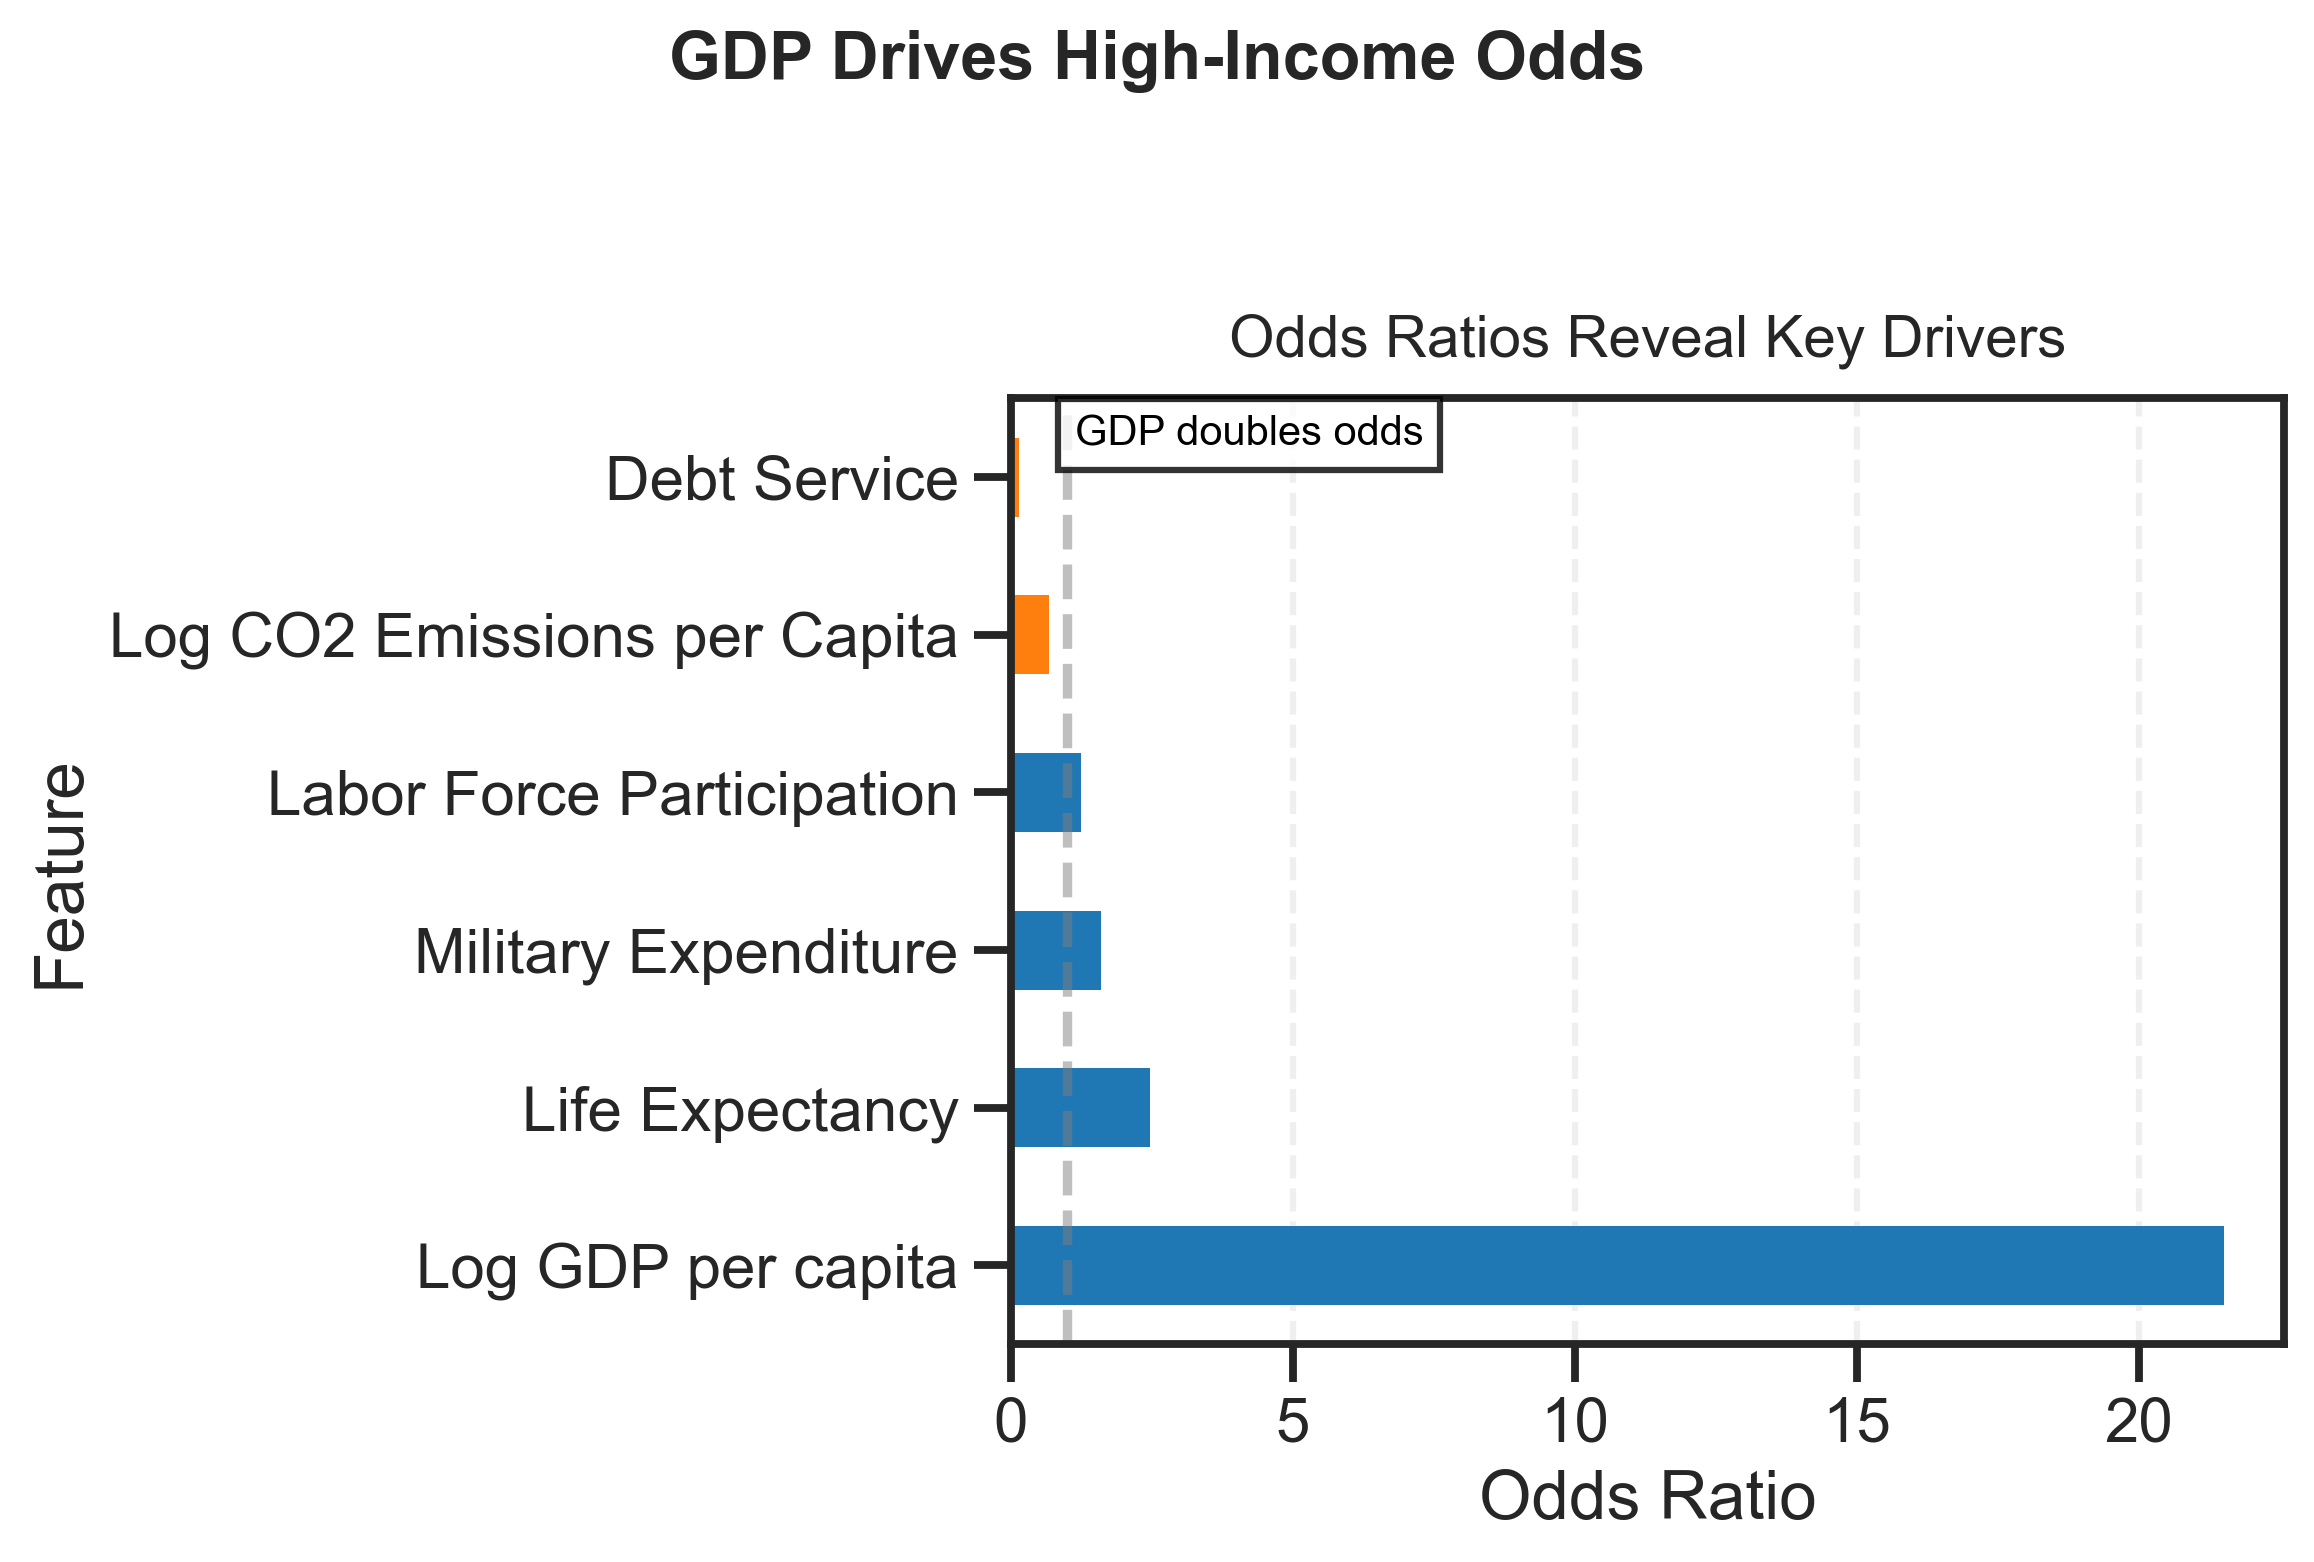

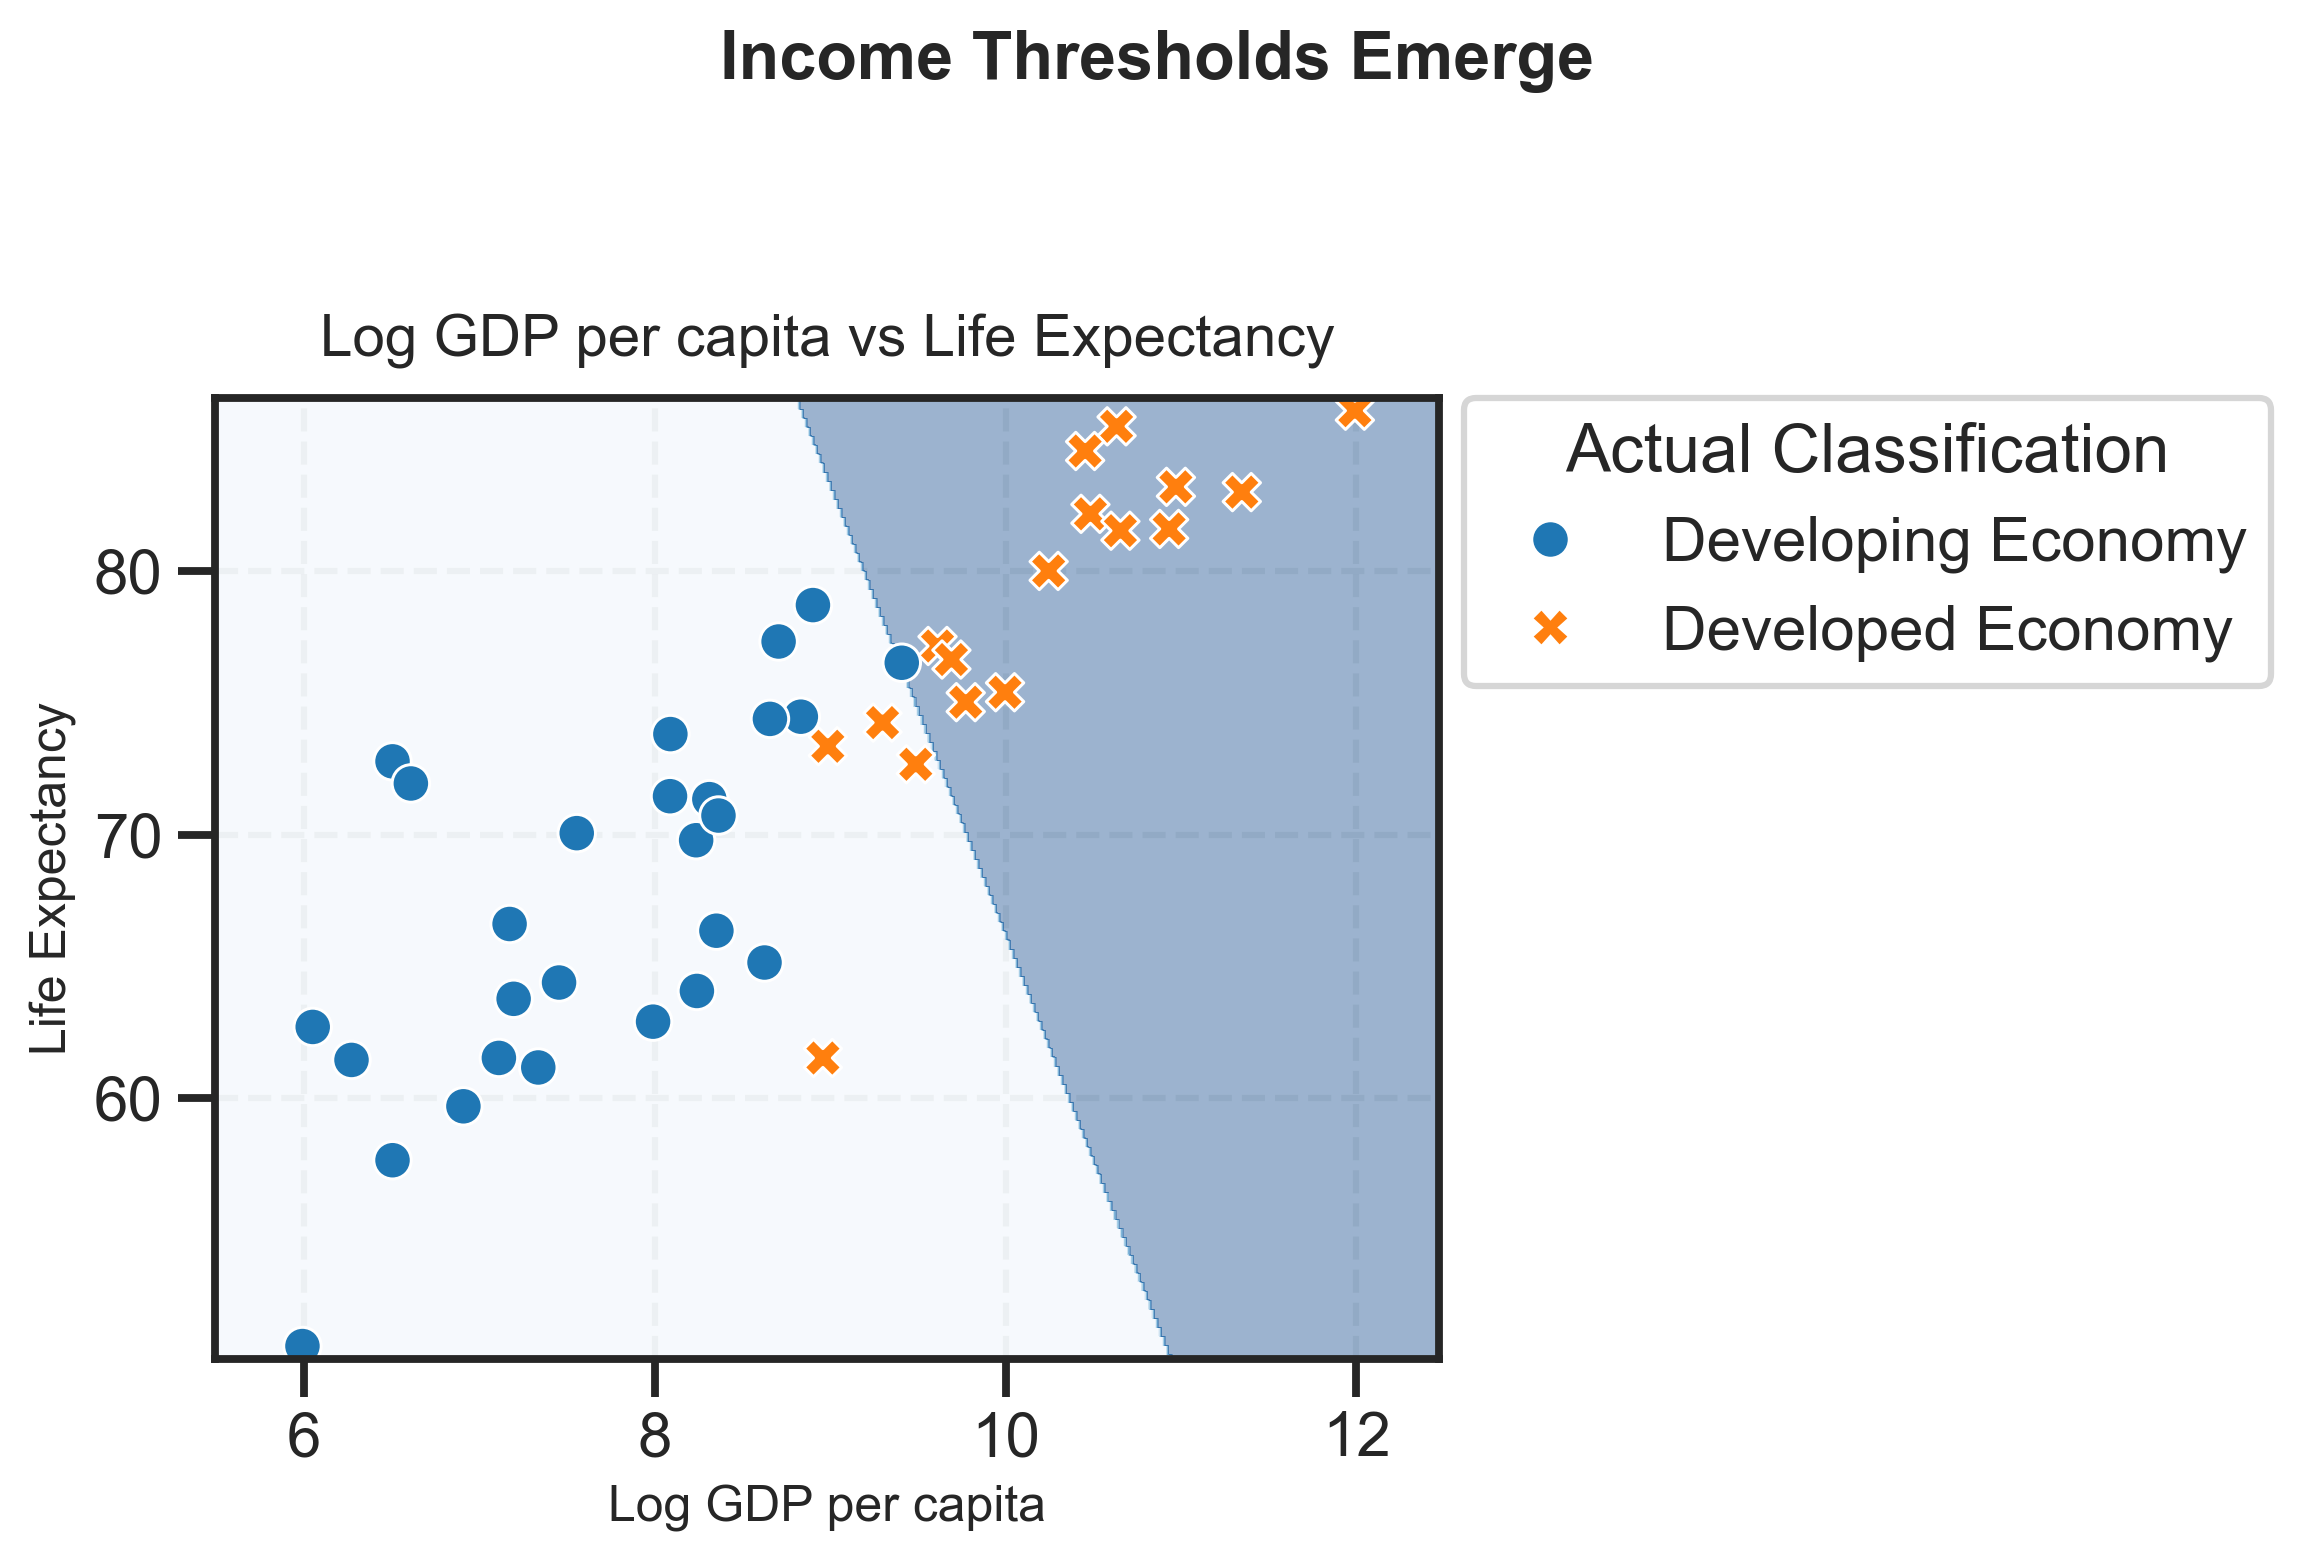

,Feature,Odds Ratio
0,Log GDP per capita,21.507653
2,Life Expectancy,2.464438
4,Military Expenditure,1.605065
3,Labor Force Participation,1.252356
1,Log CO2 Emissions per Capita,0.674736
5,Debt Service,0.148041


In [10]:
def plot_feature_importance(pipeline, feature_names):
    """Visualize odds ratios and decision boundaries."""
    coefficients = pipeline.named_steps['classifier'].coef_[0]
    odds_ratios = np.exp(coefficients)

    # Plot odds ratios
   # Plot odds ratios
    fig = plt.figure(figsize=(8, 5), dpi=300)
    fig.suptitle('GDP Drives High-Income Odds', fontsize=16, fontweight='bold', y=1.05)
    ax = fig.add_subplot(111)
    importance = pd.DataFrame({'Feature': feature_names, 'Odds Ratio': odds_ratios})
    importance = importance.sort_values('Odds Ratio', ascending=False)
    colors = ['#1f77b4' if x >= 1 else '#ff7f0e' for x in importance['Odds Ratio']]
    importance.plot(kind='barh', x='Feature', y='Odds Ratio', ax=ax, color=colors, legend=False)
    ax.set_title('Odds Ratios Reveal Key Drivers', fontsize=14, pad=10)
    ax.set_xlabel('Odds Ratio')
    ax.axvline(1, linestyle='--', color='gray', alpha=0.5)
    ax.grid(True, axis='x', linestyle='--', alpha=0.3)
    ax.text(0.05, 0.95, 'GDP doubles odds', transform=ax.transAxes, fontsize=10,
            color='black', bbox=dict(facecolor='white', alpha=0.8))
    plt.tight_layout()
    plt.show()

    # Decision boundary for top features
    top_features = importance['Feature'].head(2).values
    fig = plt.figure(figsize=(8, 5), dpi=300)
    fig.suptitle('Income Thresholds Emerge', fontsize=16, fontweight='bold', y=1.05)
    ax = fig.add_subplot(111)
    x_min, x_max = X_test[top_features[0]].min() - 0.5, X_test[top_features[0]].max() + 0.5
    y_min, y_max = X_test[top_features[1]].min() - 0.5, X_test[top_features[1]].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
    
    # Create X_mesh with all features in the correct order
    X_mesh = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=top_features)
    # Add other features with mean values, ensuring correct order
    for feat in feature_names:
        if feat not in top_features:
            X_mesh[feat] = X_test[feat].mean()
    X_mesh = X_mesh[feature_names]  # Reorder columns to match original order

    Z = pipeline.predict(X_mesh)
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.4, cmap='Blues')
    scatter=  sns.scatterplot(data=X_test, x=top_features[0], y=top_features[1], hue=y_test, style=y_test,
                    ax=ax, palette=['#1f77b4', '#ff7f0e'])
    ax.set_xlabel(top_features[0], fontsize=12)
    ax.set_ylabel(top_features[1], fontsize=12)
    ax.set_title(f'{top_features[0]} vs {top_features[1]}', fontsize=14, pad=10)
     # Custom legend
    handles, labels = scatter.get_legend_handles_labels()
    ax.legend(
        handles[:2],
        ['Developing Economy', 'Developed Economy'],
        title="Actual Classification",
        bbox_to_anchor=(1.02, 1),
        borderaxespad=0,
        frameon=True
    )
    ax.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

    return importance

print("Basic Model - Odds Ratios:")
importance_basic = plot_feature_importance(basic_pipeline, features)
display(importance_basic)

## Conclusions and Key Findings

In [11]:
def generate_report(metrics, importance_basic):
    """Generate and display a storytelling report."""
    report = "# Logistic Regression Reveals Income Drivers\n\n"
    
    report += "## Model Performance\n"
    report += f"- **Basic F1 Score**: **{metrics['Basic']['Test']['F1']:.2%}**\n\n"
    report += f"- **Basic ROC-AUC**: **{metrics['Basic']['Test']['ROC-AUC']:.2%}**\n"
    report += f"- **Advanced F1 Score**: **{metrics['Advanced']['Test']['F1']:.2%}**\n"
    report += f"- **Advanced ROC-AUC**: **{metrics['Advanced']['Test']['ROC-AUC']:.2%}**\n"
    report += "- **Insight**: Polynomial features enhance non-linear fits.\n\n"
    
    report += "## Key Drivers\n"
    report += "| Feature | Odds Ratio |\n"
    report += "|---------|------------|\n"
    for _, row in importance_basic.head(5).iterrows():
        report += f"| {row['Feature']} | {row['Odds Ratio']:.2f} |\n"
       
    display(Markdown(report))

generate_report(metrics, importance_basic)

# Logistic Regression Reveals Income Drivers

## Model Performance
- **Basic F1 Score**: **93.75%**

- **Basic ROC-AUC**: **99.78%**
- **Advanced F1 Score**: **93.75%**
- **Advanced ROC-AUC**: **100.00%**
- **Insight**: Polynomial features enhance non-linear fits.

## Key Drivers
| Feature | Odds Ratio |
|---------|------------|
| Log GDP per capita | 21.51 |
| Life Expectancy | 2.46 |
| Military Expenditure | 1.61 |
| Labor Force Participation | 1.25 |
| Log CO2 Emissions per Capita | 0.67 |


## Policy Implications
Our logistic regression models classify countries as high-income with high accuracy, revealing **GDP per capita** and **Life Expectancy** as dominant drivers. These insights guide policies for economic growth and sustainability

- **Economic Growth**: High GDP doubles high-income odds, suggesting investment focus.
- **Health Policies**: Life expectancy boosts income status, prioritizing healthcare.
- **Environmental Balance**: CO2 emissions link to wealth, necessitating green strategies.
- **Military Spending**: Moderate influence, suggesting efficient budget allocation.